In [39]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from torch.distributions import OneHotCategoricalStraightThrough, kl_divergence
import timeit
import numpy as np
import einops

In [40]:


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [41]:
class Encoder(nn.Module):
    def __init__(self, n_input=784, n_latent=20):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(n_input,512)
        self.logits_encoder = nn.Linear(512, n_latent)

        
    def forward(self,x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.fc1(z))
        return self.logits_encoder(z) 
    
class Decoder(nn.Module):
    def __init__(self, n_input=784, n_latent=20):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_latent, 512)
        self.fc2 = nn.Linear(512, n_input)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.reshape(-1,1,28,28)
    
class SparseBinaryVariationalAutoencoder(nn.Module):
    def __init__(self, n_input=784, shape=(8,8)):
        super(SparseBinaryVariationalAutoencoder, self).__init__()
        n_latent = shape[0] * shape[1]
        self.encoder = Encoder(n_input, n_latent)
        self.decoder = Decoder(n_input, n_latent)
        self.prior = OneHotCategoricalStraightThrough(logits=torch.zeros(shape))
        self.shape = shape
        
    def forward(self,x):
        logits = self.encoder(x)
        logits = logits.reshape(-1, *self.shape)
        dist = OneHotCategoricalStraightThrough(logits=logits)
        z = dist.rsample()
        z = torch.flatten(z, start_dim=1)
        return self.decoder(z), dist

In [42]:


def vae_loss(x_recon, x, dist, prior):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = kl_divergence(dist, prior)
    return BCE + KLD.mean()


def train(autoencoder, data, epochs = 50):
    print("Start training")
    start_time = timeit.default_timer()
    opt = torch.optim.Adam(autoencoder.parameters())
    for e in range(epochs):
        epoch_loss = 0
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_recon, dist = autoencoder(x)
            loss = vae_loss(x_recon, x, dist, autoencoder.prior)
            loss.backward()
            epoch_loss += loss.mean()
            opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss} Time: {current_time - start_time:.0f}" )
    return autoencoder

In [43]:
shape = (8,8)
input_dims = 784

autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)

test_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=False),
        batch_size=10,
        shuffle=True)


Start training
Done 0th epoch, Loss: 12915202.0 Time: 6
Done 1th epoch, Loss: 12235248.0 Time: 11
Done 2th epoch, Loss: 10962148.0 Time: 16
Done 3th epoch, Loss: 10566041.0 Time: 22
Done 4th epoch, Loss: 10067596.0 Time: 27
Done 5th epoch, Loss: 9041697.0 Time: 33
Done 6th epoch, Loss: 8540728.0 Time: 38
Done 7th epoch, Loss: 8288542.5 Time: 44
Done 8th epoch, Loss: 8089414.0 Time: 49
Done 9th epoch, Loss: 7946360.0 Time: 55
Done 10th epoch, Loss: 7820676.0 Time: 60
Done 11th epoch, Loss: 7739703.0 Time: 66
Done 12th epoch, Loss: 7679334.5 Time: 71
Done 13th epoch, Loss: 7625537.0 Time: 76
Done 14th epoch, Loss: 7570221.5 Time: 82
Done 15th epoch, Loss: 7534449.5 Time: 87
Done 16th epoch, Loss: 7501452.0 Time: 93
Done 17th epoch, Loss: 7475707.5 Time: 98
Done 18th epoch, Loss: 7452903.5 Time: 104
Done 19th epoch, Loss: 7443264.5 Time: 109
Done 20th epoch, Loss: 7423161.0 Time: 115
Done 21th epoch, Loss: 7401574.0 Time: 121
Done 22th epoch, Loss: 7382611.0 Time: 126
Done 23th epoch, Los

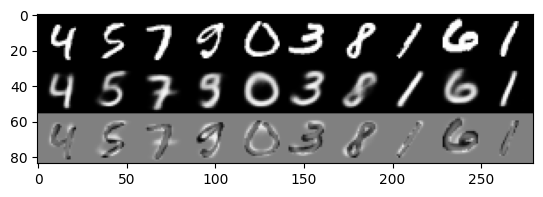

In [98]:
x, y = next(iter(test_data))

with torch.no_grad():
    x_recon, dist = autoencoder(x.to(device))
    diff = ((x_recon - x)+1)/2.0 
    img = torch.cat([x, x_recon, diff], 2)
    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    img = img.to('cpu').detach().numpy()
    # img = (img +1) /2
plt.figure()
plt.imshow(img, 'gray'  )
plt.savefig('output/vae_sampling.png')
    
   

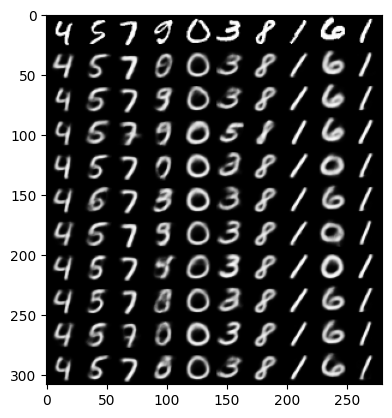

In [111]:
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    z = dist.sample()
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

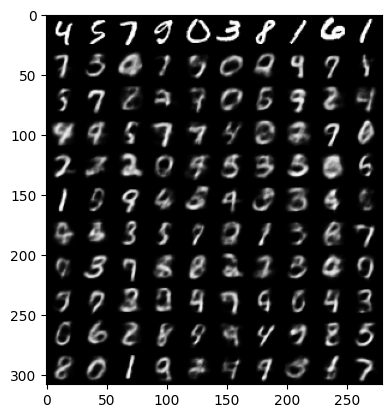

In [129]:
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    a = torch.zeros(10)
    z = autoencoder.prior.sample(a.size())
    # z = einops.rearrange(z, 'a b -> 1 (a b)')
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

# Changing the latent and see the effects

In [131]:
shape = (2,8)
# prior = OneHotCategoricalStraightThrough(logits=torch.zeros(shape))
# prior.sample()
input_dims = 784


autoencoder = SparseBinaryVariationalAutoencoder(input_dims, shape)

data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)

test_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True,
                          train=False),
        batch_size=10,
        shuffle=True)

Start training
Done 0th epoch, Loss: 13132584.0 Time: 5
Done 1th epoch, Loss: 12385613.0 Time: 11
Done 2th epoch, Loss: 12383489.0 Time: 16
Done 3th epoch, Loss: 12380858.0 Time: 21
Done 4th epoch, Loss: 12379290.0 Time: 27
Done 5th epoch, Loss: 12378265.0 Time: 32
Done 6th epoch, Loss: 12377122.0 Time: 37
Done 7th epoch, Loss: 12375835.0 Time: 43
Done 8th epoch, Loss: 12375551.0 Time: 48
Done 9th epoch, Loss: 12374089.0 Time: 53
Done 10th epoch, Loss: 12373160.0 Time: 59
Done 11th epoch, Loss: 12373577.0 Time: 64
Done 12th epoch, Loss: 12372551.0 Time: 69
Done 13th epoch, Loss: 12372024.0 Time: 74
Done 14th epoch, Loss: 12371337.0 Time: 79
Done 15th epoch, Loss: 12371211.0 Time: 85
Done 16th epoch, Loss: 12370213.0 Time: 90
Done 17th epoch, Loss: 12369992.0 Time: 95
Done 18th epoch, Loss: 12371192.0 Time: 100
Done 19th epoch, Loss: 12369482.0 Time: 106
Done 20th epoch, Loss: 12370086.0 Time: 111
Done 21th epoch, Loss: 12369948.0 Time: 116
Done 22th epoch, Loss: 12369635.0 Time: 122
Do

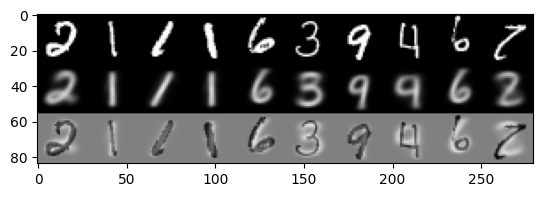

In [132]:
x, y = next(iter(test_data))

with torch.no_grad():
    x_recon, dist = autoencoder(x.to(device))
    diff = ((x_recon - x)+1)/2.0 
    img = torch.cat([x, x_recon, diff], 2)
    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    img = img.to('cpu').detach().numpy()
    # img = (img +1) /2
plt.figure()
plt.imshow(img, 'gray'  )
plt.savefig('output/vae_sampling.png')

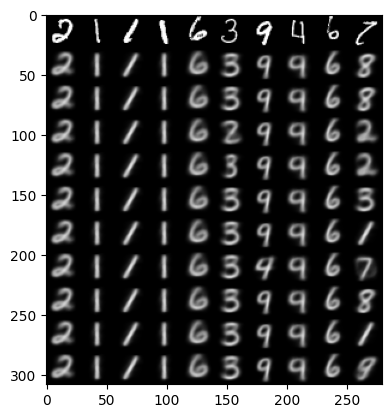

In [133]:
samples = x.clone()
samples = einops.rearrange(samples,'b c h w ->  h (b w) c')

for i in range(10):
    z = dist.sample()
    z = torch.flatten(z, start_dim=1)
    img = autoencoder.decoder(z)
    

    img = einops.rearrange(img, 'b c h w ->  h (b w) c')
    samples = torch.cat((samples, img), dim=0)
    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

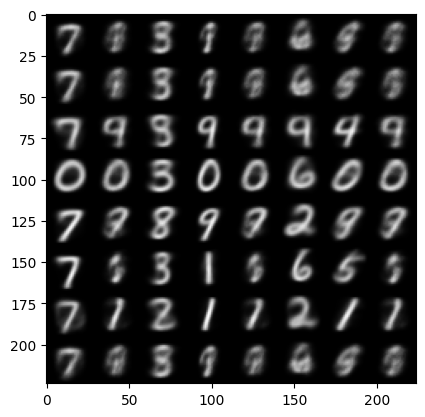

In [148]:
samples = torch.zeros(( 28*8, 28*8))


for i in range(8):
    for j in range(8):
        z = torch.zeros((2,8))
        z[0,j] = 1
        z[1, i] = 1
        z = einops.rearrange(z, 'a b -> 1 (a b)')
        # z = torch.flatten(z, start_dim=1)
        img = autoencoder.decoder(z)
        samples[28*i:28*(i+1), 28*j:28*(j+1)] = img[0,0,:,:]


    
img = samples.to('cpu').detach().numpy()    
plt.figure()
plt.imshow(img, 'gray'  )

In [146]:
img[0,0,:,:].shape

torch.Size([28, 28])

In [147]:
samples[28*i:28*(i+1), 28*j:28**(j+1)].shape

torch.Size([28, 196])